<a href="https://colab.research.google.com/github/ahmedhazemfekry/Products-Classificarion-Neural-Network/blob/dev/AmazonToysExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import Dependices { form-width: "10%" }
import pandas as pd
import numpy as np
import tensorflow as tf

import nltk
nltk.download('punkt')

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from tensorflow.keras import layers


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
#@title Loading Data Amazon toys { output-height: 30, form-width: "10%", display-mode: "both" }


#Loading Data
data = pd.read_csv("amazon_co-ecommerce_sample.csv",engine='python') 
data = data.dropna(subset=['amazon_category_and_sub_category']) # Drop the empty category elements
data = data.drop_duplicates(subset=['product_name'])            # Drop the duplicates

# Extract the product name and category columns
data = data[['product_name','amazon_category_and_sub_category']]

products_names = data["product_name"].tolist()
product_categories = data["amazon_category_and_sub_category"].tolist()

# Extract Only the High-Level Category
for idx, value in enumerate(product_categories):
  l = value.split('>')
  product_categories[idx]=l[0]


In [0]:
#@title Preparing Labels for Training { form-width: "10%" }

def get_Uniques_Categories_Set():
    Labels_List = []
    Categories  = []
    for Category in product_categories:
        if not Category in Categories:
           Categories.append(Category)       
    return Categories

# Unique Set of Categories : 43 Category
categories_set = get_Uniques_Categories_Set()

def get_targets_arrays():       
                
    labels = np.zeros([len(product_categories), len(categories_set)])
    classes = np.zeros(len(product_categories))
    
    for idx,val in enumerate(product_categories):
      target_idx = categories_set.index(val)
      # define product category array like : [0,0,0,0,1,0,0,0,0]
      product_class = np.zeros(len(categories_set))
      product_class[target_idx]=1
      labels[idx]=product_class
      classes[idx]=target_idx
    
    return labels,classes
  
# Labels Ready For Training
labels_vectors,labels_classes = get_targets_arrays()


In [5]:
#@title  Gensim Model Training on Products Names { form-width: "10%" }


tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(products_names)]

max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =0)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
W0508 00:22:13.079101 140111807432576 base_any2vec.py:1182] Effective 'alpha' higher than previous training cycles
W0508 00:25:11.291620 140111807432576 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


Model Saved


In [0]:
#@title Preparing Product Names for Training { form-width: "10%" }

def ConvertProductName(name):
    model= Doc2Vec.load("d2v.model")
    #to find the vector of a document which is not in training data
    test_data = word_tokenize(name.lower())
    v1 = model.infer_vector(test_data)
    #print("V1_infer", v1)
    # to find most similar doc using tags
    # similar_doc = model.docvecs.most_similar('1')
    return v1
  
def get_Product_Vectors(model):
    Vectors_List = np.zeros([len(model),20])
    for idx in range(len(model)):
        Vectors_List[idx]=model[idx]
    return Vectors_List

products_vectors = get_Product_Vectors(model.docvecs)

In [0]:
#@title Neural Network

In [6]:
# keras.datasets.imdb is broken in 1.13 and 1.14, by np 1.16.3
!pip install tf_nightly
!pip install -q pyyaml  # Required to save models in YAML format

In [10]:
import math
train_size = math.floor(0.8*len(products_vectors))
validation_size = train_size + math.floor(0.1*len(products_vectors))
test_size = validation_size + math.floor(0.1*len(products_vectors))

print(train_size,validation_size,test_size)
print(len(products_vectors))

7422 8349 9276
9278


In [11]:
import sklearn.model_selection as sk

train_data, test_data, train_labels, test_labels  = sk.train_test_split(products_vectors, labels_vectors, test_size=0.1, random_state=1)

train_data, val_data, train_labels, val_labels  = sk.train_test_split(train_data, train_labels, test_size=0.1, random_state=1)

'''
train_data = products_vectors[0:train_size]
train_labels = labels_vectors[0:train_size]

val_data = products_vectors[train_size+1:validation_size]
val_labels = labels_vectors[train_size+1:validation_size]

test_data = products_vectors[validation_size+1:len(products_vectors)-1]
test_labels = labels_vectors[validation_size+1:len(products_vectors)-1]
'''

'\ntrain_data = products_vectors[0:train_size]\ntrain_labels = labels_vectors[0:train_size]\n\nval_data = products_vectors[train_size+1:validation_size]\nval_labels = labels_vectors[train_size+1:validation_size]\n\ntest_data = products_vectors[validation_size+1:len(products_vectors)-1]\ntest_labels = labels_vectors[validation_size+1:len(products_vectors)-1]\n'

In [112]:
#@title Building ML Model and Training { form-width: "10%" }

ML_model = tf.keras.Sequential([
# Adds a densely-connected layer with units to the model:
layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu', input_shape=(20,)),  
# Drop Out Layers
layers.Dropout(0.3),
# Add another:
layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
# Drop Out Layers
layers.Dropout(0.3),

# Add a softmax layer with 43 output units:
layers.Dense(len(categories_set), activation='softmax')])

ML_model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



history = ML_model.fit(train_data, train_labels, epochs=300, batch_size=512,
          validation_data=(val_data, val_labels), verbose=2)

Train on 7515 samples, validate on 835 samples
Epoch 1/300
 - 1s - loss: 3.5524 - acc: 0.1166 - val_loss: 2.9370 - val_acc: 0.1916
Epoch 2/300
 - 0s - loss: 2.6954 - acc: 0.2222 - val_loss: 2.3046 - val_acc: 0.3880
Epoch 3/300
 - 0s - loss: 2.2882 - acc: 0.3287 - val_loss: 1.9768 - val_acc: 0.4850
Epoch 4/300
 - 0s - loss: 2.0489 - acc: 0.4003 - val_loss: 1.7674 - val_acc: 0.5341
Epoch 5/300
 - 0s - loss: 1.8909 - acc: 0.4496 - val_loss: 1.6492 - val_acc: 0.5557
Epoch 6/300
 - 0s - loss: 1.7825 - acc: 0.4828 - val_loss: 1.5703 - val_acc: 0.5928
Epoch 7/300
 - 0s - loss: 1.7202 - acc: 0.5107 - val_loss: 1.5276 - val_acc: 0.5952
Epoch 8/300
 - 0s - loss: 1.6834 - acc: 0.5194 - val_loss: 1.4813 - val_acc: 0.5976
Epoch 9/300
 - 0s - loss: 1.6206 - acc: 0.5399 - val_loss: 1.4547 - val_acc: 0.6072
Epoch 10/300
 - 0s - loss: 1.5874 - acc: 0.5508 - val_loss: 1.4297 - val_acc: 0.6156
Epoch 11/300
 - 0s - loss: 1.5639 - acc: 0.5552 - val_loss: 1.4059 - val_acc: 0.6311
Epoch 12/300
 - 0s - loss: 

In [113]:
results = ML_model.evaluate(test_data, test_labels)

928/928 [==============================] - 0s 54us/sample - loss: 1.0751 - acc: 0.7166


In [114]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

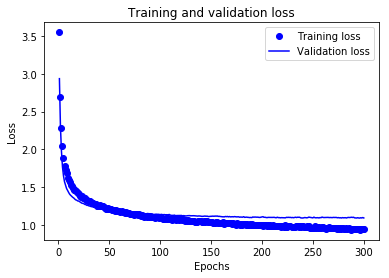

In [115]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

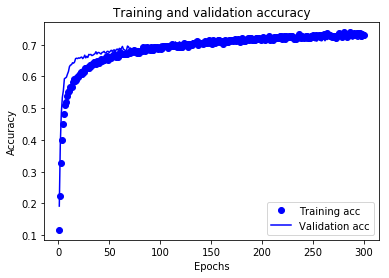

In [116]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#@title Supported Vector Machines


In [0]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

n_samples = len(products_vectors)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    products_vectors, labels_classes, test_size=0.2, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-7],
                     'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

In [31]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=1)

clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1000, gamma = 0.001 , kernel="rbf"))
#clf = svm.SVC(C=1000, gamma = 0.001, kernel="rbf")
scores = cross_validate(clf,products_vectors, labels_classes, cv=cv, return_train_score=True)
#prediction = cross_val_predict(clf, X, y, cv=4)
scores

{'fit_time': array([5.86529207, 5.99291682, 5.94227457, 5.9882617 , 6.00218797,
        5.8963511 , 5.97803211, 5.93309402, 6.02375412, 5.85369182,
        5.904181  , 5.89656162, 5.9374342 , 5.95687437, 5.96700668,
        5.8323431 , 5.76658201, 5.79371572, 5.79806542, 6.04461837]),
 'score_time': array([1.16093111, 1.07728624, 1.07634902, 1.10706973, 1.05597425,
        1.0999186 , 1.07628775, 1.13749862, 1.01137924, 1.07650876,
        1.07810569, 1.09510207, 1.09336615, 1.05497265, 1.09953189,
        1.08495212, 0.99328232, 1.1000402 , 1.10433245, 1.1192646 ]),
 'test_score': array([0.68965517, 0.69827586, 0.68696121, 0.69073276, 0.6950431 ,
        0.68642241, 0.69989224, 0.67834052, 0.69073276, 0.67618534,
        0.69881466, 0.67510776, 0.67025862, 0.68911638, 0.69127155,
        0.70581897, 0.69288793, 0.69073276, 0.69127155, 0.68857759]),
 'train_score': array([0.79210455, 0.78455942, 0.78860146, 0.78900566, 0.7864457 ,
        0.78765831, 0.78482889, 0.79170035, 0.78887092,

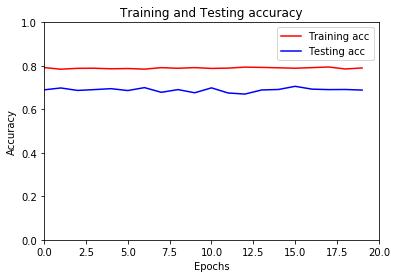

In [32]:
import matplotlib.pyplot as plt

plt.clf()   # clear figure

plt.plot(scores['train_score'], 'r', label='Training acc')
plt.plot(scores['test_score'], 'b', label='Testing acc')
plt.axis([0,20,0,1])
plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()